In [7]:
import gym

import numpy as np

from tqdm import tqdm_notebook

import random
import math

import matplotlib
import matplotlib.pyplot as plt

In [8]:
class QTable():
    def __init__(self, num_actions=4):
        self.num_actions = num_actions
        #a dictionary of (s, a) pairs
        self.Q = {}
    
    def get_Q(self, s, a):
        self.check(s)
        return self.Q[s][a]

    def check(self, s):
        if not s in self.Q:
            self.Q[s] = [0.]*self.num_actions
    
    def get_max_Q(self, s):
        self.check(s)
        return np.max(self.Q[s])
    
    def set_Q(self, s, a, q):
        self.check(s)
        self.Q[s][a] = q
    
    def get_max_a_for_Q(self, s):
        self.check(s)
        if np.min(self.Q[s]) == np.max(self.Q[s]):
            return random.choice([i for i in range(self.num_actions)]) # if all values are equal then do a random choice
        else:
            return np.argmax(self.Q[s])

In [14]:
def get_bins_dense(mx, mn, num_one_side):
    return np.hstack([
        -np.geomspace(mn, mx, num=num_one_side)[::-1],
        np.array([0.0]),
        np.geomspace(mn, mx, num=num_one_side)
    ])

class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.Q = QTable(num_actions=2)
        self.alpha = 0.1
        self.gamma = 0.99

        self.position_bins = np.array(np.linspace(-2.41, 2.41, 1))
        self.velocity_bins = np.array(np.linspace(-3, 3, 1))
        self.angle_bins = np.array(get_bins_dense(math.radians(10), 0.01, 3))
        self.tip_velocity_bins = np.array(get_bins_dense(math.radians(20), 0.02, 3))

#         print(f"{self.position_bins}\n{self.velocity_bins}\n{self.angle_bins}\n{self.tip_velocity_bins}\n")
        
        self.durations = []
    
    def get_epsilon(self, iteration, max_iterations, high=1.0, low=0.01):
        #exponentially decrease
        return (low / high) ** (iteration / max_iterations)
    
    def getAction(self, s, episode, episodes):
        #epsilon greedy
        if np.random.rand() < self.get_epsilon(episode, episodes):
            action = self.env.action_space.sample()
        else:
            action = self.Q.get_max_a_for_Q(s)

        return action
    def getBestAction(self, s):
        return self.Q.get_max_a_for_Q(s)
    
    def discretize(self, state):
        return (
                    np.digitize([state[0]], self.position_bins).item(),
                    np.digitize([state[1]], self.velocity_bins).item(),
                    np.digitize([state[2]], self.angle_bins).item(),
                    np.digitize([state[3]], self.tip_velocity_bins).item()
                )

    def train(self, episodes=100):

        for episode in tqdm_notebook(range(episodes)):
            state = self.env.reset()

            steps = 0
            s = self.discretize(state)

            while True:
                action = self.getAction(s, episode, episodes)

                s_next, reward, done, _ = self.env.step(action)
                if done and steps < 199:
                    reward = -100

                s_next = self.discretize(s_next)

                q = self.Q.get_Q(s, action)
                next_state_value = self.Q.get_max_Q(s_next) * (1 - done)

                q_better = q + self.alpha * (reward + self.gamma * next_state_value - q)
                self.Q.set_Q(s, action, q_better)

                s = s_next

                steps += 1

                if done:
                    break
            
            self.durations.append(steps)

            if episode % 100 == 0:
                print(f"episode: {episode} done | Duration: {self.durations[-1]}")
        
    def plot_stuff(self, num_avg=10):
        plt.figure(figsize=(15, 8))
        plt.plot(self.durations, label="episode lengths")
        tmp = [0] * num_avg + self.durations
        averaged_durations = [sum(tmp[i:i+num_avg]) / num_avg for i in range(len(self.durations))]
        plt.plot(averaged_durations, label="ep lengths moving avg")
        plt.grid(b=True, which='both')
        plt.legend(loc='upper left')
        plt.show()
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getBestAction(self.discretize(s))
            s_1, reward, done, info = self.env.step(action)
            steps += 1
            s = s_1
            if done:
                print("Episode finished after {} timesteps".format(steps))
                break
        self.env.close()

episode: 0 done | Duration: 12
episode: 100 done | Duration: 28
episode: 200 done | Duration: 187
episode: 300 done | Duration: 33
episode: 400 done | Duration: 48
episode: 500 done | Duration: 200
episode: 600 done | Duration: 200
episode: 700 done | Duration: 200
episode: 800 done | Duration: 200
episode: 900 done | Duration: 200



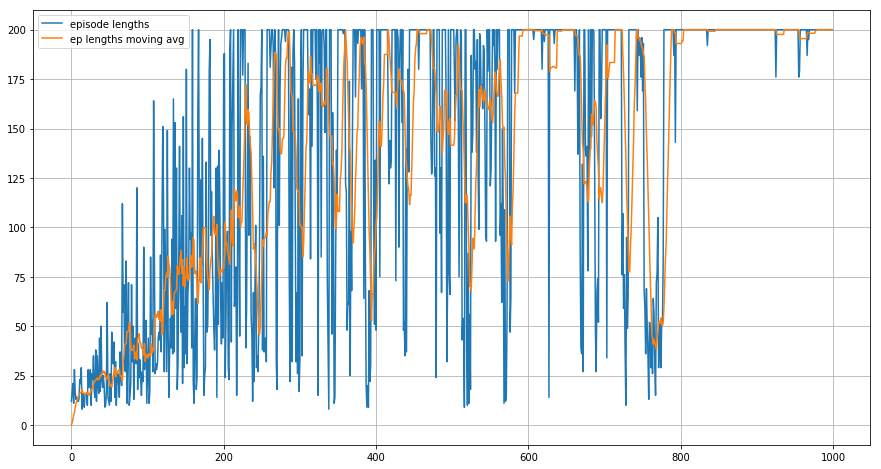

In [15]:
agent = Agent()
agent.train(episodes=1000)
agent.plot_stuff()

In [9]:
#show a few sample runs
for i in tqdm_notebook(range(3)):
    agent.run()

Episode finished after 200 timesteps
Episode finished after 200 timesteps
Episode finished after 200 timesteps

